#MLP From Stratch (Sigmoid Activation, MSE Loss)

#Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
%matplotlib inline

In [2]:
import time
import numpy as np
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch

Settings and DataSet

In [3]:
randomSeed = 1
numEpochs = 50
batchSize = 100

In [4]:
trainData = datasets.MNIST(root='data',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

testData = datasets.MNIST(root='data',
                          train=False,
                          transform = transforms.ToTensor())

trainLoader = DataLoader(dataset = trainData, batch_size = batchSize, shuffle=True)
testLoader  = DataLoader(dataset = testData , batch_size = batchSize, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 145297986.81it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 77750766.25it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 34315059.45it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 11869488.33it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [5]:
for images,labels in trainLoader:
  print('Image batch dimensions: ', images.shape)
  print('Label batch dimensions: ', labels.shape)
  break

Image batch dimensions:  torch.Size([100, 1, 28, 28])
Label batch dimensions:  torch.Size([100])


###Model

In [6]:
class MLP():

  def __init__(self,numFeatures,numHidden,numClasses):
    super(MLP,self).__init__()
    self.numClasses = numClasses
    self.weightLinear = torch.zeros(numHidden, numFeatures,dtype = torch.float).normal_(0,0.1)
    self.biasLinear = torch.zeros(numHidden, dtype= torch.float)
    self.weightOut = torch.zeros(numClasses,numHidden, dtype = torch.float).normal_(0,0.1)
    self.biasOut = torch.zeros(numClasses, dtype= torch.float)

  def forward(self,x):
    z1 = torch.mm(x,self.weightLinear.t()) + self.biasLinear
    a1 = torch.sigmoid(z1)

    z2 = torch.mm(a1,self.weightOut.t()) + self.biasOut
    a2 = torch.sigmoid(z2)

    return a1,a2

  def backward(self,x,a1,a2,y):

    #####
    ## Output layer weights
    #####

    yOneHot = torch.FloatTensor(y.size(0), self.numClasses)
    yOneHot.zero_()
    yOneHot.scatter_(1, y.view(-1,1).long(),1)
    dloss_da2 = 2*(a2 - yOneHot)/y.size(0)
    da2_dz2 = a2 * (1-a2)
    delta_out = dloss_da2 * da2_dz2
    dz2_dwOut = a1
    dloss_dwOut = torch.mm(delta_out.t(), dz2_dwOut)
    dloss_dbOut = torch.sum(delta_out, dim=0)
    dz2_a1 = self.weightOut
    dloss_a1 = torch.mm(delta_out,dz2_a1)
    da1_dz1 = a1 * (1-a1)
    dz1_dw1 = x
    dloss_dw1 = torch.mm((dloss_a1*da1_dz1).t(),dz1_dw1)
    dloss_db1 = torch.sum((dloss_a1*da1_dz1), dim =0)
    return dloss_dwOut, dloss_dbOut, dloss_dw1, dloss_db1


###Training

In [7]:
#####
##Training

def toOneHot(y,numClasses):
  yOneHot = torch.FloatTensor(y.size(0),numClasses)
  yOneHot.zero_()
  yOneHot.scatter_(1,y.view(-1,1).long(),1).float()
  return yOneHot

def lossFunc(targetsOneHot, probasOneHot):
  return torch.mean(torch.mean(targetsOneHot - probasOneHot)**2, dim=0)

def computeMean(net,dataLoader):
  currMSE,numExamples = torch.zeros(model.numClasses).float() , 0
  with torch.no_grad():
    for features,targets in dataLoader:
      features = features.view(-1,28*28)
      logits,probas = net.forward(features)
      yOneHot = toOneHot(targets,model.numClasses)
      loss = torch.sum((yOneHot - probas)**2, dim=0)
      numExamples+=targets.size(0)
      currMSE+=loss
    currMSE = torch.mean(currMSE/numExamples, dim=0)
    return currMSE

def train(model, trainLoader,numEpochs,learningRate=0.1):
  miniBatchCost = []
  epochCost = []

  for e in range(numEpochs):
    for batchIDx, (features,targets) in enumerate(trainLoader):
      features = features.view(-1,784)
      a1,a2 = model.forward(features)
      dloss_dwOut, dloss_dbOut, dloss_dw1, dloss_db1 = model.backward(features,a1,a2,targets)

      model.weightLinear-=learningRate*dloss_dw1
      model.biasLinear  -=learningRate*dloss_db1
      model.weightOut   -=learningRate*dloss_dwOut
      model.biasOut     -=learningRate*dloss_dbOut

      ####Logging
      currCost = lossFunc(toOneHot(targets,model.numClasses),a2)
      miniBatchCost.append(currCost)
      if not batchIDx % 50:
        print("Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f" %(e+1,numEpochs,batchIDx,len(trainLoader),currCost))
    currCost = computeMean(model,trainLoader)
    epochCost.append(currCost)
    print("Epoch: %03d/%03d | Cost: %.4f" %(e+1,numEpochs,currCost))
  return miniBatchCost, epochCost


In [8]:
###Training
torch.manual_seed(randomSeed)
model = MLP(28*28,50,10)
miniBatchCost, epochCost = train(model,trainLoader,numEpochs,0.1)



Epoch: 001/050 | Batch 000/600 | Cost: 0.1418
Epoch: 001/050 | Batch 050/600 | Cost: 0.0001
Epoch: 001/050 | Batch 100/600 | Cost: 0.0000
Epoch: 001/050 | Batch 150/600 | Cost: 0.0001
Epoch: 001/050 | Batch 200/600 | Cost: 0.0001
Epoch: 001/050 | Batch 250/600 | Cost: 0.0002
Epoch: 001/050 | Batch 300/600 | Cost: 0.0004
Epoch: 001/050 | Batch 350/600 | Cost: 0.0006
Epoch: 001/050 | Batch 400/600 | Cost: 0.0008
Epoch: 001/050 | Batch 450/600 | Cost: 0.0008
Epoch: 001/050 | Batch 500/600 | Cost: 0.0010
Epoch: 001/050 | Batch 550/600 | Cost: 0.0011
Epoch: 001/050 | Cost: 0.0658
Epoch: 002/050 | Batch 000/600 | Cost: 0.0013
Epoch: 002/050 | Batch 050/600 | Cost: 0.0015
Epoch: 002/050 | Batch 100/600 | Cost: 0.0015
Epoch: 002/050 | Batch 150/600 | Cost: 0.0013
Epoch: 002/050 | Batch 200/600 | Cost: 0.0015
Epoch: 002/050 | Batch 250/600 | Cost: 0.0017
Epoch: 002/050 | Batch 300/600 | Cost: 0.0013
Epoch: 002/050 | Batch 350/600 | Cost: 0.0013
Epoch: 002/050 | Batch 400/600 | Cost: 0.0013
Epoc

###Model Evaluation

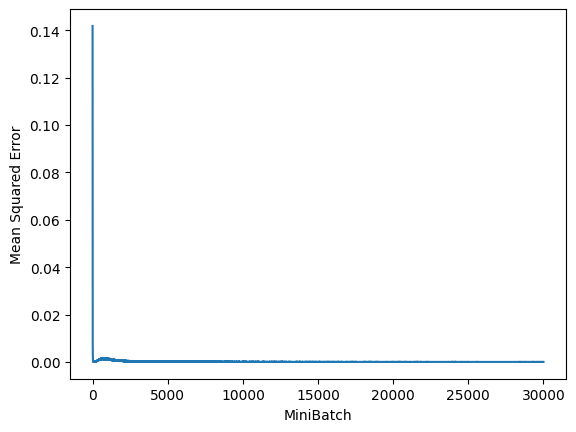

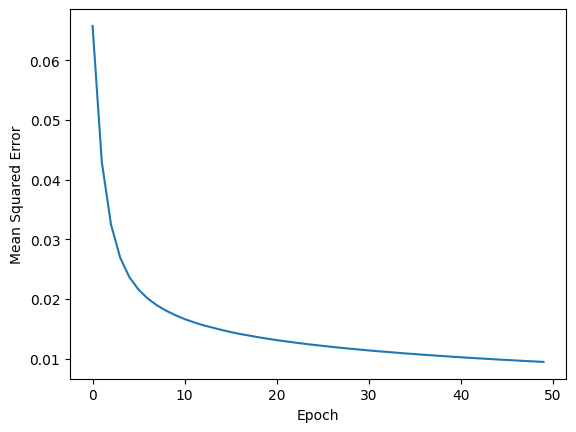

In [9]:
plt.plot(range(len(miniBatchCost)),miniBatchCost)
plt.ylabel("Mean Squared Error")
plt.xlabel("MiniBatch")
plt.show()

plt.plot(range(len(epochCost)),epochCost)
plt.ylabel("Mean Squared Error")
plt.xlabel("Epoch")
plt.show()

In [10]:
def computeAcc(net,dataLoader):
  correctPred,numExamples = 0 , 0
  with torch.no_grad():
    for features,targets in dataLoader:
      features = features.view(-1,28*28)
      logits,probas = net.forward(features)
      pred = torch.argmax(probas,1)
      numExamples+=targets.size(0)
      correctPred+=(pred==targets).sum()
      # yOneHot = toOneHot(targets,model.numClasses)
      # loss = torch.sum((yOneHot - probas)**2, dim=0)
      # numExamples+=targets.size(0)
      # currMSE+=loss
    # currMSE = torch.mean(currMSE/numExamples, dim=0)
    return correctPred.float()/numExamples * 100


In [11]:
print("Training Accuracy :%.2f%%" % (computeAcc(model,trainLoader)))
print("Testing  Accuracy :%.2f%%" % (computeAcc(model,testLoader )))


Training Accuracy :94.71%
Testing  Accuracy :94.51%


###Visual Evaluation

In [12]:
# %matplot inline
import matplotlib


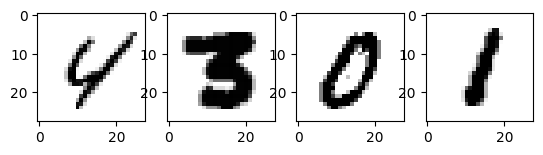

In [13]:
for features,targets in testLoader:
  break

fig,ax = plt.subplots(1,4)
for i in range(4):
  ax[i].imshow(features[i].view(28,28), cmap=matplotlib.cm.binary)

plt.show()

In [15]:
_, pred = model.forward(features[:4].view(-1,28*28))
pred = torch.argmax(pred,dim=1)
print("Predicted Labels",pred)


Predicted Labels tensor([4, 3, 0, 1])
